In [1]:
import polars as pl
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import statistics
from numpy import typing as npt
import more_itertools as mit
from returns.curry import partial
from matplotlib.gridspec import GridSpec


# Load data

In [2]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()


In [3]:
df = pl.read_csv(TRAIN_FILE_PATH)
df


id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
i64,i64,str,i64,str,i64,i64,str,i64,i64,str,i64,i64,i64,str,i64,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,36,"""Travel_Frequen...",599,"""Research & Dev...",24,3,"""Medical""",1,4,"""Male""",42,3,1,"""Laboratory Tec...",4,"""Married""",2596,5099,1,"""Y""","""Yes""",13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,"""Travel_Rarely""",921,"""Sales""",8,3,"""Other""",1,1,"""Male""",46,3,1,"""Sales Represen...",1,"""Married""",2899,10778,1,"""Y""","""No""",17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,"""Travel_Rarely""",718,"""Sales""",26,3,"""Marketing""",1,3,"""Male""",80,3,2,"""Sales Executiv...",4,"""Divorced""",4627,16495,0,"""Y""","""No""",17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,"""Travel_Rarely""",1488,"""Research & Dev...",2,3,"""Medical""",1,3,"""Female""",40,3,2,"""Healthcare Rep...",1,"""Married""",5347,13384,3,"""Y""","""No""",14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,"""Travel_Rarely""",1017,"""Research & Dev...",5,4,"""Medical""",1,2,"""Female""",37,3,5,"""Manager""",1,"""Single""",19033,19805,1,"""Y""","""Yes""",13,3,3,80,0,31,0,3,31,14,4,10,1
5,27,"""Travel_Rarely""",566,"""Research & Dev...",2,3,"""Other""",1,3,"""Female""",56,3,2,"""Manufacturing ...",2,"""Single""",4197,7103,5,"""Y""","""No""",11,3,4,80,0,6,0,3,1,0,1,0,0
6,34,"""Travel_Rarely""",944,"""Research & Dev...",10,4,"""Medical""",1,2,"""Male""",36,3,1,"""Laboratory Tec...",1,"""Single""",1281,16900,1,"""Y""","""No""",13,3,1,80,0,1,2,3,1,0,0,0,0
7,40,"""Travel_Rarely""",1009,"""Research & Dev...",2,3,"""Life Sciences""",1,4,"""Male""",74,3,1,"""Laboratory Tec...",4,"""Divorced""",3067,12916,2,"""Y""","""No""",12,3,4,80,1,6,3,2,3,2,1,2,0
8,51,"""Travel_Frequen...",1297,"""Sales""",6,3,"""Life Sciences""",1,4,"""Male""",43,1,2,"""Sales Executiv...",4,"""Married""",6439,21221,8,"""Y""","""Yes""",13,3,1,80,1,18,3,3,16,14,4,9,0


# Check for missing values

In [4]:
df.null_count()


id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Visualize the data

In [5]:
def plot_counts_and_target_factor(
    df: pl.DataFrame,
    *,
    target_column_name: str,
    column_name: str,
    left_ax: plt.Axes,
    right_ax: plt.Axes,
) -> None:
    target_values = df.select(pl.col(target_column_name).unique().alias("target")).sort(
        "target"
    )["target"]
    aggs = [pl.count().alias("count")]
    for target_value in target_values:
        aggs.append(
            (
                pl.col(target_column_name)
                .filter(pl.col(target_column_name) == target_value)
                .count()
                / pl.count()
            ).alias(f"count_{target_value}_factor")
        )
    grouped_df = df.groupby([column_name]).agg(aggs).sort(["count"])

    indices = np.arange(len(grouped_df))
    bars = left_ax.barh(indices, grouped_df["count"])
    left_ax.set_yticks(indices, grouped_df[column_name])
    left_ax.bar_label(bars, fmt="%d")
    left_ax.set_title(f"Counts for {column_name}")

    prev_series: pl.Series | None = None
    for target_value in target_values:
        series = grouped_df[f"count_{target_value}_factor"]
        right_ax.barh(
            indices,
            series,
            label=f"{target_column_name}={target_value}",
            left=prev_series,
        )
        prev_series = series
    right_ax.set_yticks(indices, grouped_df[column_name])
    right_ax.legend()
    right_ax.set_title(f"Target factor for {column_name}")


In [6]:
def plot_histogram_and_target_factor(
    df: pl.DataFrame,
    *,
    target_column_name: str,
    column_name: str,
    bins: int | None = None,
    left_ax: plt.Axes,
    right_ax: plt.Axes,
) -> None:
    if bins is None:
        # automatically adjust the number of bins
        n_unique_values = df.select(pl.col(column_name).n_unique()).item()
        bins = min(n_unique_values, 20)

    total_series = df[column_name]
    (hist, brackets, _) = left_ax.hist(total_series, bins=bins)
    left_ax.set_title(f"{column_name} distribution")
    x = list(map(statistics.mean, mit.sliding_window(brackets, 2)))
    bracket_width = brackets[1] - brackets[0]

    target_values = df.select(pl.col(target_column_name).unique().alias("target")).sort(
        "target"
    )["target"]
    series = (
        df.filter(pl.col(target_column_name) == target_value)[column_name]
        for target_value in target_values
    )
    histograms = (np.histogram(series, bins=brackets)[0] for series in series)
    factors = (histogram / hist for histogram in histograms)
    prev_factor: npt.NDarray[np.float64] | None = None
    for target_value, factor in zip(target_values, factors):
        right_ax.bar(
            x,
            factor,
            width=bracket_width,
            label=f"{target_column_name}={target_value}",
            bottom=prev_factor,
        )
        prev_factor = factor
    right_ax.legend()
    right_ax.set_title(f"Target factor for {column_name}")


In [7]:
def plot_columns_and_target_factors(
    df: pl.DataFrame, *, target_column_name: str, excluded_columns: set[str]
) -> None:
    column_types = dict(zip(df.columns, df.dtypes))
    del column_types[target_column_name]
    for column_name in excluded_columns:
        del column_types[column_name]
    column_types

    n_attrs = len(column_types)
    fig = plt.figure(figsize=(20, 4 * n_attrs))
    gs = GridSpec(n_attrs, 2, figure=fig)
    for idx, (column_name, column_type) in enumerate(column_types.items()):
        left_ax = fig.add_subplot(gs[idx, 0])
        right_ax = fig.add_subplot(gs[idx, 1])
        if column_type in {pl.Boolean, pl.Utf8}:
            plot_counts_and_target_factor(
                df,
                target_column_name=target_column_name,
                column_name=column_name,
                left_ax=left_ax,
                right_ax=right_ax,
            )
        else:
            plot_histogram_and_target_factor(
                df,
                target_column_name=target_column_name,
                column_name=column_name,
                left_ax=left_ax,
                right_ax=right_ax,
            )


/tmp/ipykernel_658123/882783698.py:29: RuntimeWarning: invalid value encountered in divide
  factors = (histogram / hist for histogram in histograms)


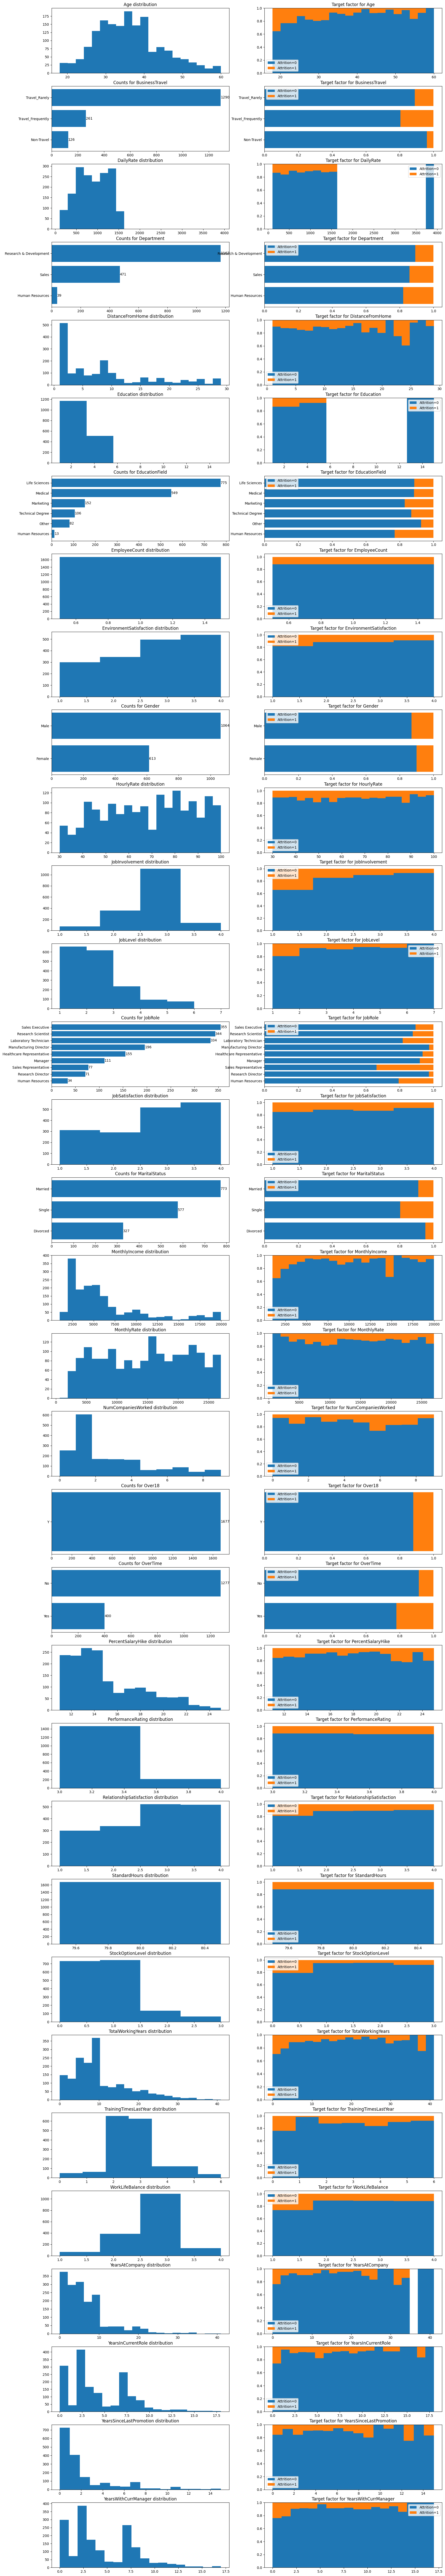

In [8]:
plot_columns_and_target_factors(
    df, target_column_name="Attrition", excluded_columns={"id"}
)


# `DailyRate` column

There is an outlier

In [9]:
hist, buckets = np.histogram(df['DailyRate'], bins=40)
hist

array([ 53,  37,  69, 100, 150, 145, 103, 153, 131,  95, 121, 146, 163,
       126,  84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1])

Let's drop the outlier.

In [10]:
df = df.filter(pl.col('DailyRate') < pl.col('DailyRate').max())

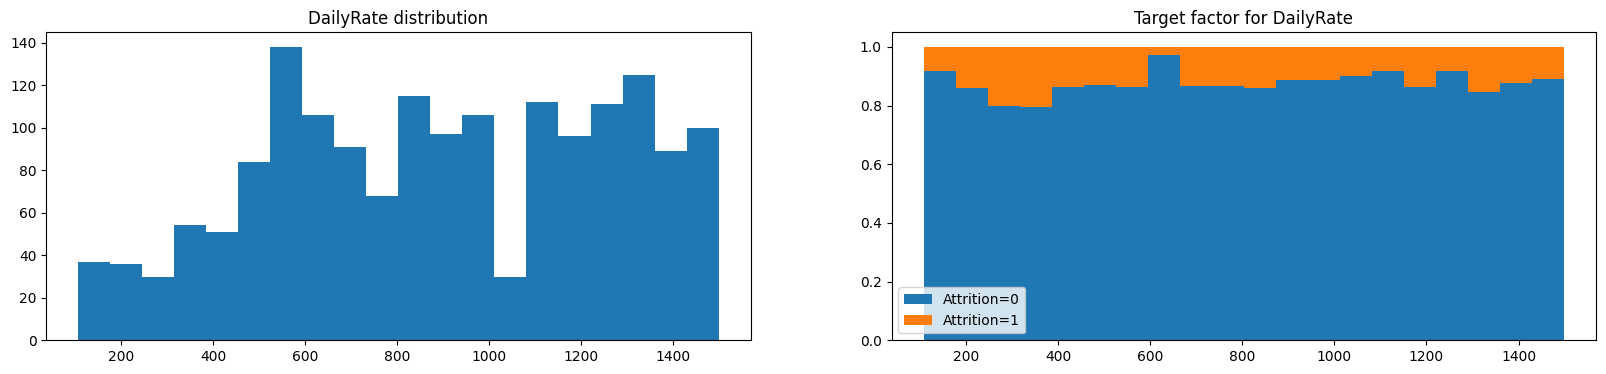

In [11]:
_, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(20, 4))
plot_histogram_and_target_factor(
    df,
    target_column_name="Attrition",
    column_name="DailyRate",
    left_ax=left_ax,
    right_ax=right_ax,
)

Looks good now.

# `Education` column

There is an outlier in `Education`

In [12]:
df['Education'].value_counts()

Education,counts
i64,u32
15,1
5,44
4,464
3,681
2,304
1,182


Let's drop the outlier.

In [13]:
df = df.filter(pl.col('Education') < pl.col('Education').max())

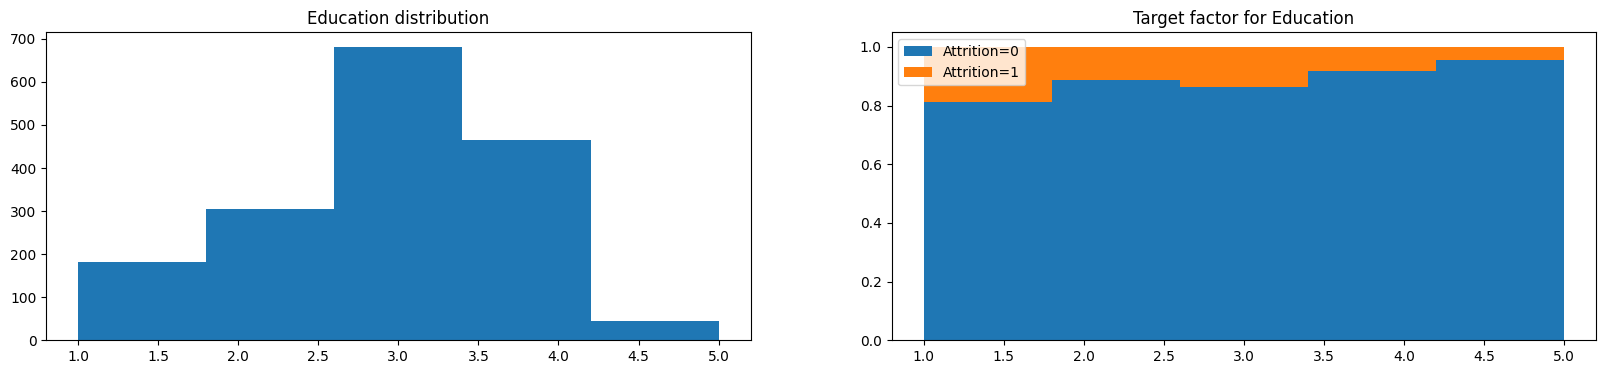

In [14]:
_, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(20, 4))
plot_histogram_and_target_factor(
    df,
    target_column_name="Attrition",
    column_name="Education",
    left_ax=left_ax,
    right_ax=right_ax,
)

Looks better now.

# `EmployeeCount` column

In [15]:
df['EmployeeCount'].value_counts()

EmployeeCount,counts
i64,u32
1,1675


There is no information in this column. We can get rid of it.

In [16]:
# drop constant columns
_ = df.drop_in_place('EmployeeCount')

# `Over18` column

In [17]:
df['Over18'].value_counts()

Over18,counts
str,u32
"""Y""",1675


There is no information in this column. We can get rid of it.

In [18]:
_ = df.drop_in_place('Over18')

# `StandardHours` column

In [19]:
df['StandardHours'].value_counts()

StandardHours,counts
i64,u32
80,1675


There is no information in this column. We can get rid of it.

In [20]:
_ = df.drop_in_place('StandardHours')

# Re-generate the visualizaton

/tmp/ipykernel_658123/882783698.py:29: RuntimeWarning: invalid value encountered in divide
  factors = (histogram / hist for histogram in histograms)


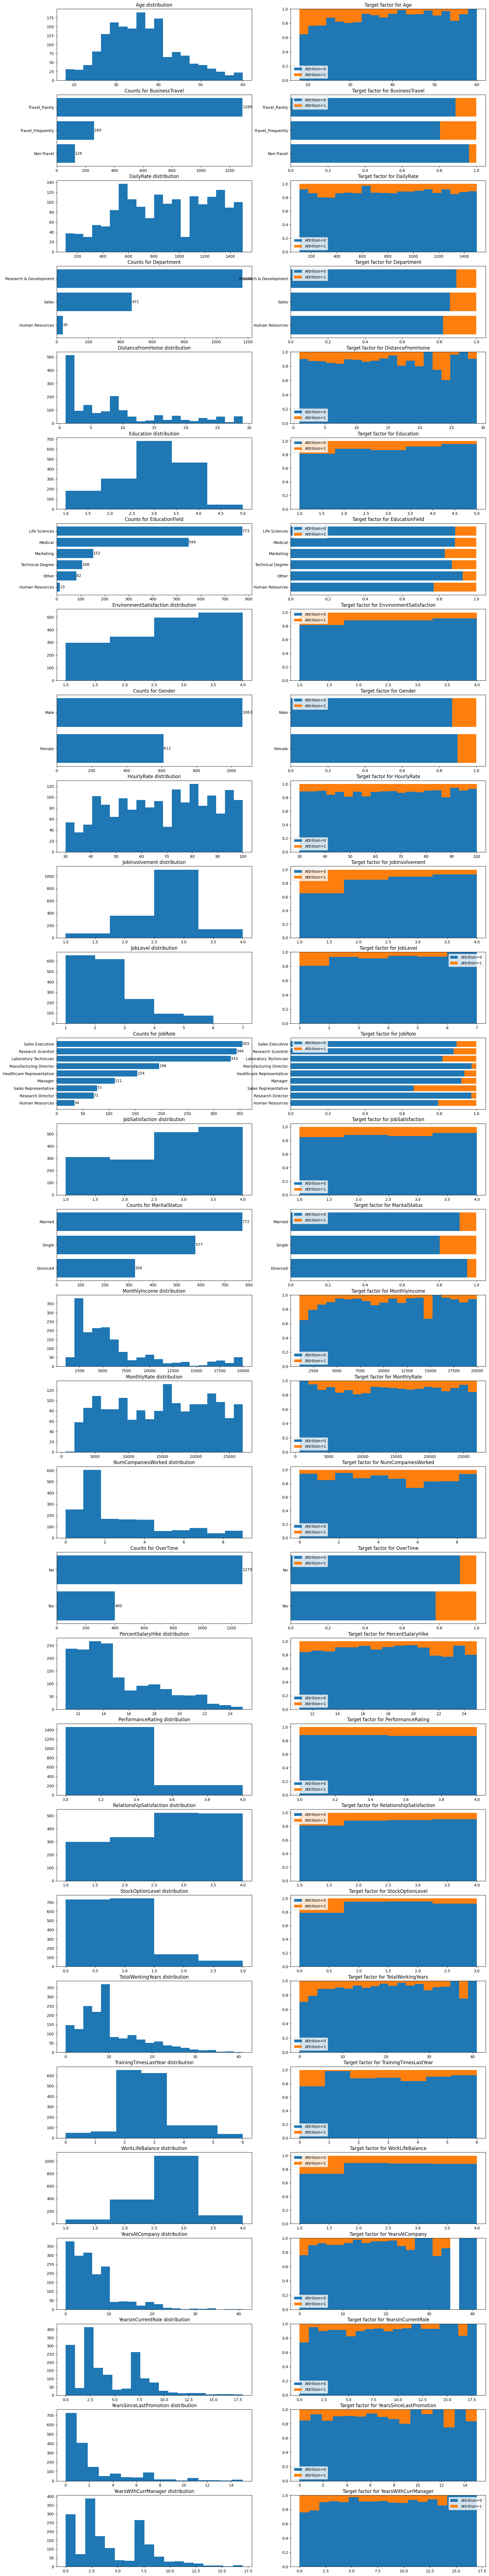

In [21]:
plot_columns_and_target_factors(df, target_column_name="Attrition", excluded_columns={"id"})

# Export adjusted dataset

In [22]:
df.write_csv('train_cleaned.csv')